In [5]:
import requests
import pandas as pd

url = "https://api.coingecko.com/api/v3/coins/markets"

params = {
    "vs_currency": "usd",
    "order": "market_cap_desc",
    "per_page": 50,   # pull more so filtering still leaves ~20
    "page": 1,
    "sparkline": False
}

response = requests.get(url, params=params)
data = response.json()

df = pd.DataFrame(data)[
    ["market_cap_rank", "symbol", "name", "market_cap", "current_price"]
]

# -----------------------------
# Filters
# -----------------------------

stablecoins = {
    "usdt", "usdc", "busd", "dai", "tusd",
    "usdp", "fdusd", "gusd", "lusd",
    "ust", "ustc", "usdd", "eurc",'usds','usde','bsc-usd','usd1','pyusd'
    
}

# normalize text
df["symbol"] = df["symbol"].str.lower()
df["name"] = df["name"].str.lower()

# remove stablecoins
df = df[~df["symbol"].isin(stablecoins)]

# remove wrapped coins
df = df[
    ~df["name"].str.contains("wrapped") &
    ~df["symbol"].str.startswith("w")
]

# take top 20 after filtering
df = df.sort_values("market_cap", ascending=False).head(20)

print(df)


    market_cap_rank      symbol          name     market_cap  current_price
0                 1         btc       bitcoin  1339162673069   66974.000000
1                 2         eth      ethereum   235405590443    1950.640000
3                 4         xrp           xrp    83627017531       1.380000
4                 5         bnb           bnb    80680518333     591.840000
6                 7         sol        solana    46076145120      81.260000
7                 8         trx          tron    25982649744       0.274366
8                 9  figr_heloc  figure heloc    15549052648       1.032000
9                10        doge      dogecoin    15182282849       0.090043
11               12         bch  bitcoin cash    10235797411     512.200000
13               14         ada       cardano     9357738576       0.254699
14               15         leo     leo token     7666040812       8.320000
15               16        hype   hyperliquid     6828842322      28.690000
17          

In [6]:
binance_symbols = requests.get(
    "https://api.binance.com/api/v3/exchangeInfo"
).json()

binance_assets = {
    s["baseAsset"].lower()
    for s in binance_symbols["symbols"]
    if s["quoteAsset"] == "USDT"
}

df = df[df["symbol"].isin(binance_assets)]

In [7]:
df

,market_cap_rank,symbol,name,market_cap,current_price
0,1,btc,bitcoin,1339162673069,66974.000000
1,2,eth,ethereum,235405590443,1950.640000
3,4,xrp,xrp,83627017531,1.380000
4,5,bnb,bnb,80680518333,591.840000
6,7,sol,solana,46076145120,81.260000
7,8,trx,tron,25982649744,0.274366
9,10,doge,dogecoin,15182282849,0.090043
11,12,bch,bitcoin cash,10235797411,512.200000
13,14,ada,cardano,9357738576,0.254699
17,18,xmr,monero,6338695980,342.910000


In [9]:
from binance.client import Client
import datetime
client = Client()


end_date = datetime.datetime.now()
start_date = end_date - datetime.timedelta(days=60)

klines_btc = client.get_historical_klines(
    "BTCUSDT",                     # symbol
    Client.KLINE_INTERVAL_15MINUTE,    # interval:15 minutes
    start_date.strftime("%d %b %Y %H:%M:%S"),
    end_date.strftime("%d %b %Y %H:%M:%S")
)
df_btc = pd.DataFrame(klines_btc, columns=[
    "timestamp", "open", "high", "low", "close", "volume",
    "close_time", "quote_asset_volume", "number_of_trades",
    "taker_buy_base", "taker_buy_quote", "ignore"
])
df_btc=df_btc[['timestamp','close']]

klines_eth = client.get_historical_klines(
    "ETHUSDT",                     # symbol
    Client.KLINE_INTERVAL_15MINUTE,    # interval:15 minutes
    start_date.strftime("%d %b %Y %H:%M:%S"),
    end_date.strftime("%d %b %Y %H:%M:%S")
)
klines_bnb = client.get_historical_klines(
    "BNBUSDT",                     # symbol
    Client.KLINE_INTERVAL_15MINUTE,    # interval:15 minutes
    start_date.strftime("%d %b %Y %H:%M:%S"),
    end_date.strftime("%d %b %Y %H:%M:%S")
)


In [10]:
import pandas as pd
from binance.client import Client

def get_close_prices_15m(
    client,
    symbols,
    start_date,
    end_date
):
    """
    Download 15-minute close prices for selected coins.

    Parameters
    ----------
    client : Binance Client
    symbols : list[str]
        Example: ["BTC", "ETH", "BNB", "SOL"]
    start_date : datetime
    end_date : datetime

    Returns
    -------
    pd.DataFrame
        timestamp × coin close prices
    """

    close_dfs = []

    for sym in symbols:
        pair = sym.upper() + "USDT"
        print(f"Downloading {pair}")

        klines = client.get_historical_klines(
            pair,
            Client.KLINE_INTERVAL_15MINUTE,
            start_date.strftime("%d %b %Y %H:%M:%S"),
            end_date.strftime("%d %b %Y %H:%M:%S")
        )

        df = pd.DataFrame(klines, columns=[
            "timestamp", "open", "high", "low", "close", "volume",
            "close_time", "quote_asset_volume", "number_of_trades",
            "taker_buy_base", "taker_buy_quote", "ignore"
        ])

        df = df[["timestamp", "close"]]
        df["timestamp"] = pd.to_datetime(df["timestamp"], unit="ms")
        df["close"] = df["close"].astype(float)

        df = df.rename(columns={"close": sym.upper()})

        close_dfs.append(df)

    # ---- merge all coins on timestamp ----
    df_close = close_dfs[0]

    for d in close_dfs[1:]:
        df_close = df_close.merge(
            d,
            on="timestamp",
            how="outer"
        )

    df_close = (
        df_close
        .sort_values("timestamp")
        .set_index("timestamp")
    )

    return df_close


In [27]:

import datetime



#start_date = datetime(2025, 1, 1)
end_date = datetime.datetime.now()
start_date = end_date - datetime.timedelta(days=30)


df_close_15m = get_close_prices_15m(
    client,
    df['symbol'].tolist(),
    start_date,
    end_date
)


Text(0, 0.5, 'Price')

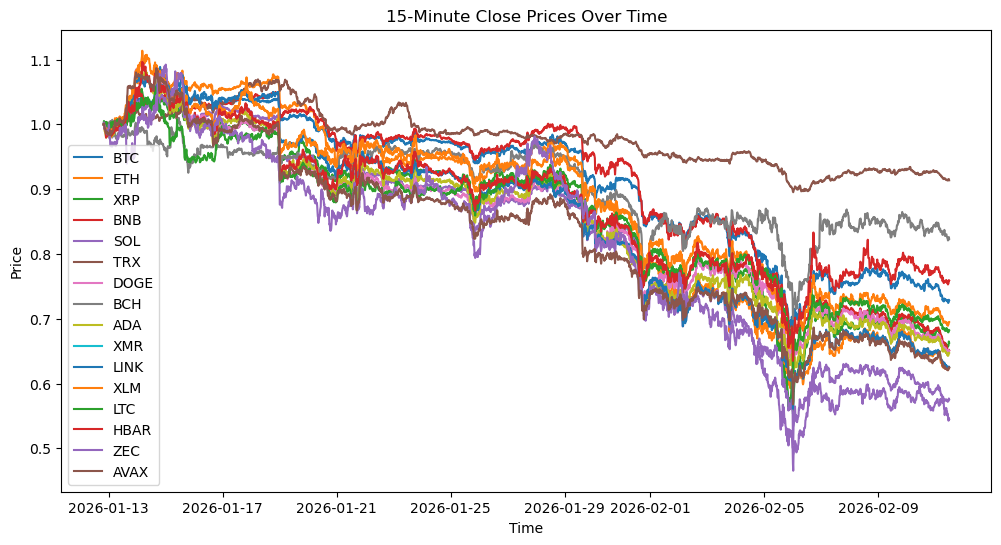

In [28]:
import matplotlib.pyplot as plt

normalized_df = df_close_15m / df_close_15m.iloc[0]  # Normalize to the first row

plt.figure(figsize=(12, 6))
for col in normalized_df.columns:
    plt.plot(normalized_df.index, normalized_df[col], label=col)
plt.legend()
plt.title("15-Minute Close Prices Over Time")
plt.xlabel("Time")
plt.ylabel("Price")

In [29]:
normalized_df.head()

,BTC,ETH,XRP,BNB,SOL,TRX,DOGE,BCH,ADA,XMR,LINK,XLM,LTC,HBAR,ZEC,AVAX
timestamp,,,,,,,,,,,,,,,,
2026-01-12 19:45:00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,NaN,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2026-01-12 20:00:00,1.000081,0.999776,1.001014,0.999625,1.002766,0.999667,1.001880,1.000644,1.000508,NaN,1.002274,1.002256,1.005248,0.999829,1.003092,1.001458
2026-01-12 20:15:00,0.998623,0.996637,1.000290,0.998612,1.000284,0.999000,0.997325,0.998391,0.995425,NaN,0.996967,0.998646,0.999738,0.995465,0.998272,0.998542
2026-01-12 20:30:00,0.995724,0.994068,0.998116,0.997444,0.995603,0.999333,0.992843,0.997425,0.989832,NaN,0.993935,0.996390,0.997770,0.993668,0.992648,0.993440
2026-01-12 20:45:00,0.995902,0.993831,0.997198,0.997169,0.994610,0.999667,0.992337,0.996299,0.989832,NaN,0.993935,0.995036,0.997770,0.992555,0.998393,0.993440


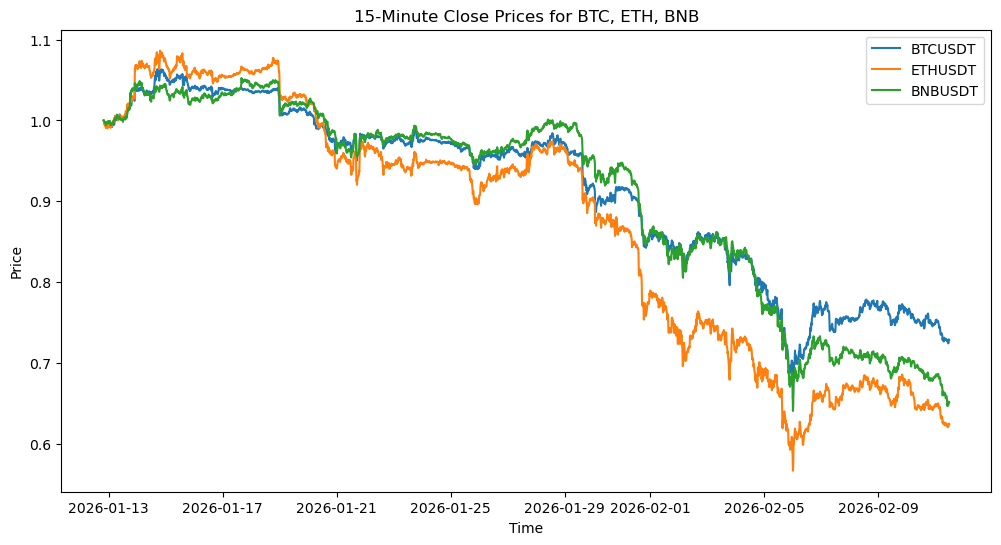

In [30]:
plt.figure(figsize=(12,6))
plt.plot(normalized_df.index, normalized_df['BTC'], label='BTCUSDT')
plt.plot(normalized_df.index, normalized_df['ETH'], label='ETHUSDT')
plt.plot(normalized_df.index, normalized_df['BNB'], label='BNBUSDT')
plt.legend()
plt.title("15-Minute Close Prices for BTC, ETH, BNB")
plt.xlabel("Time")
plt.ylabel("Price")
plt.show()

In [31]:
normalized_df.head()
# Drop columns where ALL values are NaN
df_close_15m = df_close_15m.dropna(axis=1, how='all')
normalized_df=normalized_df.dropna(axis=1, how='all')

# Or drop columns with ANY NaN values
#df_close_15m = df_close_15m.dropna(axis=1, how='any')

In [32]:
df_close_15m

,BTC,ETH,XRP,BNB,SOL,TRX,DOGE,BCH,ADA,LINK,XLM,LTC,HBAR,ZEC,AVAX
timestamp,,,,,,,,,,,,,,,
2026-01-12 19:45:00,91861.27,3121.83,2.0701,907.79,140.99,0.2999,0.13832,621.4,0.3934,13.19,0.2216,76.22,0.11686,410.78,13.72
2026-01-12 20:00:00,91868.70,3121.13,2.0722,907.45,141.38,0.2998,0.13858,621.8,0.3936,13.22,0.2221,76.62,0.11684,412.05,13.74
2026-01-12 20:15:00,91734.82,3111.33,2.0707,906.53,141.03,0.2996,0.13795,620.4,0.3916,13.15,0.2213,76.20,0.11633,410.07,13.70
2026-01-12 20:30:00,91468.50,3103.31,2.0662,905.47,140.37,0.2997,0.13733,619.8,0.3894,13.11,0.2208,76.05,0.11612,407.76,13.63
2026-01-12 20:45:00,91484.86,3102.57,2.0643,905.22,140.23,0.2998,0.13726,619.1,0.3894,13.11,0.2205,76.05,0.11599,410.12,13.63
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2026-02-11 10:30:00,66732.73,1938.05,1.3601,588.67,80.66,0.2742,0.08955,510.1,0.2529,8.21,0.1527,51.78,0.08798,225.78,8.51
2026-02-11 10:45:00,66531.99,1939.30,1.3614,587.77,80.69,0.2742,0.08967,510.3,0.2529,8.22,0.1531,51.75,0.08808,224.14,8.53
2026-02-11 11:00:00,66666.67,1942.30,1.3640,590.13,80.85,0.2742,0.08975,510.5,0.2535,8.22,0.1532,51.77,0.08821,222.91,8.54


In [33]:
import numpy as np
from itertools import combinations
from statsmodels.tsa.stattools import coint
import statsmodels.api as sm


In [34]:
def test_cointegration(series_x, series_y):
    """
    Engle-Granger 2-step cointegration test
    """

    # 1️⃣ Hedge ratio (OLS)
    X = sm.add_constant(series_x)
    model = sm.OLS(series_y, X).fit()
    beta = model.params[1]

    spread = series_y - beta * series_x

    # 2️⃣ Cointegration test
    score, pvalue, crit = coint(series_y, series_x)

    return {
        "beta": beta,
        "pvalue": pvalue,
        "t_stat": score,
        "crit_1%": crit[0],
        "crit_5%": crit[1],
        "crit_10%": crit[2],
        "spread": spread
    }


In [35]:
results = []

pairs = list(combinations(normalized_df.columns, 2))

for x, y in pairs:
    res = test_cointegration(normalized_df[x], normalized_df[y])

    results.append({
        "pair": f"{x}-{y}",
        "x": x,
        "y": y,
        "beta": res["beta"],
        "pvalue": res["pvalue"],
        "t_stat": res["t_stat"],
        "crit_5%": res["crit_5%"]
    })

df_coint = pd.DataFrame(results)


/var/folders/4m/pv0tzcg560gbwvkhsz_3dxsm0000gn/T/ipykernel_27896/905122118.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  beta = model.params[1]
/var/folders/4m/pv0tzcg560gbwvkhsz_3dxsm0000gn/T/ipykernel_27896/905122118.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  beta = model.params[1]
/var/folders/4m/pv0tzcg560gbwvkhsz_3dxsm0000gn/T/ipykernel_27896/905122118.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  beta = mo

In [44]:
df_coint[:20].sort_values("pvalue")

,pair,x,y,beta,pvalue,t_stat,crit_5%
12,BTC-ZEC,BTC,ZEC,1.460855,0.002165,-4.346467,-3.338277
1,BTC-XRP,BTC,XRP,1.142260,0.003001,-4.255499,-3.338277
3,BTC-SOL,BTC,SOL,1.410385,0.006131,-4.047813,-3.338277
10,BTC-LTC,BTC,LTC,0.939627,0.017481,-3.715886,-3.338277
19,ETH-BCH,ETH,BCH,0.375602,0.042774,-3.396202,-3.338277
9,BTC-XLM,BTC,XLM,1.098446,0.049579,-3.339097,-3.338277
14,ETH-XRP,ETH,XRP,0.788836,0.051521,-3.323996,-3.338277
16,ETH-SOL,ETH,SOL,0.976751,0.068683,-3.207495,-3.338277
6,BTC-BCH,BTC,BCH,0.541697,0.071971,-3.187921,-3.338277
7,BTC-ADA,BTC,ADA,1.149875,0.181701,-2.751215,-3.338277


In [37]:
coint_pairs = df_coint[df_coint["pvalue"] < 0.05]
coint_pairs = coint_pairs.sort_values("pvalue")
coint_pairs

,pair,x,y,beta,pvalue,t_stat,crit_5%
76,DOGE-AVAX,DOGE,AVAX,1.112444,0.000976,-4.559475,-3.338277
55,SOL-XLM,SOL,XLM,0.777426,0.000994,-4.554651,-3.338277
85,ADA-XLM,ADA,XLM,0.943290,0.001582,-4.431744,-3.338277
12,BTC-ZEC,BTC,ZEC,1.460855,0.002165,-4.346467,-3.338277
1,BTC-XRP,BTC,XRP,1.142260,0.003001,-4.255499,-3.338277
95,XLM-LTC,XLM,LTC,0.855355,0.003747,-4.192309,-3.338277
28,XRP-SOL,XRP,SOL,1.223253,0.003771,-4.190466,-3.338277
37,XRP-ZEC,XRP,ZEC,1.270656,0.004594,-4.133272,-3.338277
3,BTC-SOL,BTC,SOL,1.410385,0.006131,-4.047813,-3.338277
34,XRP-XLM,XRP,XLM,0.960772,0.008079,-3.963911,-3.338277


In [45]:
btc_pairs = coint_pairs[
    (coint_pairs["x"] == "BTC") |
    (coint_pairs["y"] == "BTC")
]

btc_pairs



,pair,x,y,beta,pvalue,t_stat,crit_5%
12,BTC-ZEC,BTC,ZEC,1.460855,0.002165,-4.346467,-3.338277
1,BTC-XRP,BTC,XRP,1.142260,0.003001,-4.255499,-3.338277
3,BTC-SOL,BTC,SOL,1.410385,0.006131,-4.047813,-3.338277
10,BTC-LTC,BTC,LTC,0.939627,0.017481,-3.715886,-3.338277
9,BTC-XLM,BTC,XLM,1.098446,0.049579,-3.339097,-3.338277


In [48]:
btc_pairs['pair'].tolist()

pairs = btc_pairs["pair"].tolist()

btc_hedges = [p.replace("BTC-", "") for p in pairs]


btc_hedges

['ZEC', 'XRP', 'SOL', 'LTC', 'XLM']

In [49]:


Y = np.log(df_close_15m["BTC"])
X = np.log(df_close_15m[btc_hedges])

data = pd.concat([Y, X], axis=1).dropna()

Y = data["BTC"]
X = data[btc_hedges]




In [38]:
df_close_15m[['BTC','ETH','SOL']].head()


,BTC,ETH,SOL
timestamp,,,
2026-01-12 19:45:00,91861.27,3121.83,140.99
2026-01-12 20:00:00,91868.70,3121.13,141.38
2026-01-12 20:15:00,91734.82,3111.33,141.03
2026-01-12 20:30:00,91468.50,3103.31,140.37
2026-01-12 20:45:00,91484.86,3102.57,140.23


In [39]:
import numpy as np
import pandas as pd
import statsmodels.api as sm

def build_spread(prices: pd.DataFrame, x: str, y: str, beta: float, use_log=True):
    px = prices[x].astype(float)
    py = prices[y].astype(float)
    if use_log:
        px = np.log(px)
        py = np.log(py)
    spread = py - beta * px
    return spread.dropna()


In [71]:
def fit_ou_from_spread(spread: pd.Series, delta=1.0):
    s = spread.values
    s_t = s[:-1]
    s_t1 = s[1:]

    X = sm.add_constant(s_t)
    res = sm.OLS(s_t1, X).fit()

    b = float(res.params[0])
    a = float(res.params[1])

    # guardrails
    if not (0 < a < 1):
        return None  # not mean-reverting in discrete-time sense

    eps = res.resid
    sd_eps = float(np.std(eps, ddof=1))

    lam = -np.log(a) / delta
    mu = b / (1 - a)
    sigma = sd_eps * np.sqrt((-2*np.log(a)) / (delta*(1 - a*a)))

    half_life = np.log(2) / lam

    return {
        "a": a, "b": b,
        "lambda": lam,
        "mu": mu,
        "sigma": sigma,
        "half_life": half_life,
        "r2": float(res.rsquared)
    }


In [41]:
def ou_zscore(spread: pd.Series, mu: float, sigma: float):
    return (spread - mu) / sigma

def percentile_signals(z: pd.Series, lookback=90, p_low=25, p_high=75, p_exit=50):
    sig = pd.Series(0, index=z.index, dtype=int)

    for i in range(lookback, len(z)):
        hist = z.iloc[i-lookback:i]
        lo = np.percentile(hist, p_low)
        hi = np.percentile(hist, p_high)
        mid = np.percentile(hist, p_exit)

        if z.iloc[i] > hi:
            sig.iloc[i] = -1   # short spread
        elif z.iloc[i] < lo:
            sig.iloc[i] = 1    # long spread
        elif (z.iloc[i-1] - mid) * (z.iloc[i] - mid) <= 0:
            sig.iloc[i] = 0    # exit when cross mid
        else:
            sig.iloc[i] = sig.iloc[i-1]  # hold previous position

    return sig


In [ ]:
def run_ou_for_pairs(pairs_df: pd.DataFrame, prices: pd.DataFrame,
                     train_frac=0.7, delta=1.0):
    results = []

    for _, row in pairs_df.iterrows():
        x, y, beta = row["x"], row["y"], float(row["beta"])

        spread = build_spread(prices, x=x, y=y, beta=beta, use_log=True)
        if len(spread) < 200:
            continue

        split = int(len(spread) * train_frac)
        train = spread.iloc[:split]
        test  = spread.iloc[split:]

        ou = fit_ou_from_spread(train, delta=delta)
        if ou is None:
            continue

        z = ou_zscore(test, ou["mu"], ou["sigma"])
        sig = percentile_signals(z, lookback=90)

        results.append({
            "pair": f"{x}-{y}",
            "beta": beta,
            **ou,
            "z": z,
            "signal": sig
        })

    return results


In [ ]:
import matplotlib.pyplot as plt

def plot_pair_signals(results_list, pair_name):
    # Find the specific result for the pair
    res = next((item for item in results_list if item["pair"] == pair_name), None)
    if res is None:
        print(f"Pair {pair_name} not found in results.")
        return

    z_score = res['z']
    signals = res['signal']
    
    plt.figure(figsize=(15, 7))
    
    # 1. Plot the Z-score of the spread
    plt.plot(z_score.index, z_score, label='Spread Z-Score', color='blue', alpha=0.6)
    


    # 3. Plot Entry/Exit markers
    # Long entries (signal changes to 1)
    long_entries = z_score[(signals == 1) & (signals.shift(1) != 1)]
    plt.scatter(long_entries.index, long_entries, color='green', marker='^', s=100, label='Long Spread')
    
    # Short entries (signal changes to -1)
    short_entries = z_score[(signals == -1) & (signals.shift(1) != -1)]
    plt.scatter(short_entries.index, short_entries, color='red', marker='v', s=100, label='Short Spread')
    
    # Exits (signal changes to 0)
    exits = z_score[(signals == 0) & (signals.shift(1) != 0)]
    plt.scatter(exits.index, exits, color='black', marker='x', s=50, label='Exit/Neutral')

    plt.title(f"Trading Signals for {pair_name}")
    plt.ylabel("Z-Score")
    plt.legend(loc='best')
    plt.grid(True, alpha=0.3)
    plt.show()

# Usage:
# plot_pair_signals(results, "BTC-ETH")

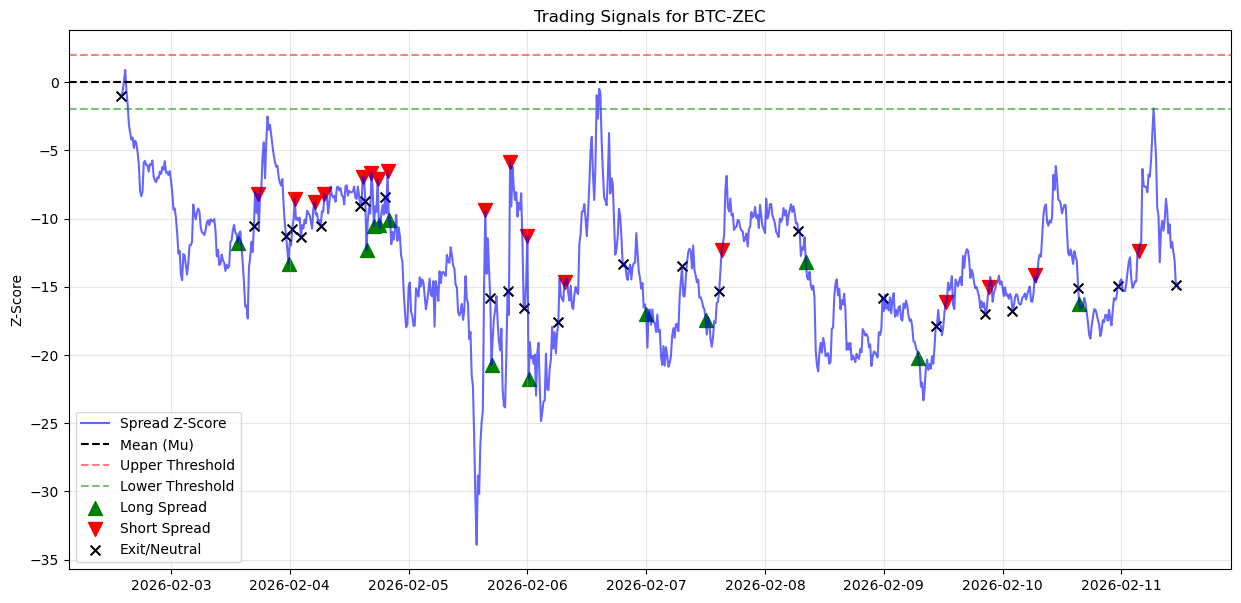

In [59]:
plot_pair_signals(results, "BTC-ZEC")